In [485]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import re
import os
import random
import torch
print(f"cuda is available: {torch.cuda.is_available()}", f"device count: {torch.cuda.device_count()}")
print(os.getcwd())

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import catboost
from catboost import CatBoostRegressor

import xgboost
from xgboost import XGBRegressor
from xgboost import plot_importance as xgb_plot_importance

import lightgbm
from lightgbm import LGBMRegressor
from lightgbm import plot_importance as lgbm_plot_importance

print(f'CatBoost Version : {catboost.__version__}')
print(f'XGBoost Version  : {xgboost.__version__}')
print(f'LightGBM Version : {lightgbm.__version__}')

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

# 경고 메시지 숨기기
import warnings
warnings.filterwarnings(action = 'ignore')

# Seed 고정
SEED = 42
def seed_everything(seed) :
    random.seed(seed)
    np.random.seed(seed)
    # tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(False) # True
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
seed_everything(SEED)

cuda is available: True device count: 1
/root/code
CatBoost Version : 1.2.2
XGBoost Version  : 2.0.2
LightGBM Version : 4.1.0


In [486]:
books = pd.read_csv('./code/data/books.csv')
users = pd.read_csv('./code/data/users.csv')
rating_train = pd.read_csv('./code/data/train_ratings.csv')
rating_test = pd.read_csv('./code/data/test_ratings.csv')
print(books.shape, users.shape, rating_train.shape, rating_test.shape)

(149570, 10) (68092, 3) (306795, 3) (76699, 3)


In [487]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149569 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             82343 non-null   object 
 7   category             80719 non-null   object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
dtypes: float64(1), object(9)
memory usage: 11.4+ MB


# ISBN (International Standard Book Number)

ISBN은 책의 고유한 번호입니다. ISBN은 총 13자리로 구성되며, 기존의 10자리 ISBN은 2007년부터 13자리로 바뀌었지만, 여전히 10자리 ISBN을 사용하는 나라도 있습니다.

그럼 먼저 ISBN 데이터를 살펴보겠습니다.

In [488]:
# isbn 데이터 분석하기

isbn = books['isbn']

# isbn의 길이가 10인 것만 추출
isbn_10 = isbn[isbn.apply(lambda x: len(str(x)) == 10)]

# isbn의 길이가 13인 것만 추출
isbn_13 = isbn[isbn.apply(lambda x: len(str(x)) == 13)]

# isbn의 길이가 10도 아니고 13도 아닌 것만 추출
isbn_else = isbn[isbn.apply(lambda x: len(str(x)) != 10 and len(str(x)) != 13)]

print(f'isbn의 길이가 10인 것의 개수 : {len(isbn_10)}')
print(f'isbn의 길이가 13인 것의 개수 : {len(isbn_13)}')
print(f'isbn의 길이가 10도 아니고 13도 아닌 것의 개수 : {len(isbn_else)}')

isbn의 길이가 10인 것의 개수 : 149570
isbn의 길이가 13인 것의 개수 : 0
isbn의 길이가 10도 아니고 13도 아닌 것의 개수 : 0


여기서 모든 데이터가 길이가 10인 것을 확인할 수 있습니다.

# ISBN 구조 분석하기

ISBN은 총 10자리로 구성되며, 각 자리는 다음과 같은 의미를 가집니다.

- 1~9번째 자리: 식별 번호
- 10번째 자리: 체크 디지트

식별 번호의 앞의 1 ~ 5자는 국가 코드를 나타냅니다.

[ISBN 국가 코드 링크](https://en.wikipedia.org/wiki/List_of_ISBN_registration_groups)

In [489]:
non_language_isbn = books[books['language'].isnull()].isbn

print(f'language가 없는 책의 개수 : {len(non_language_isbn)}')

language가 없는 책의 개수 : 67227


In [490]:
# 데이터 채우기
import isbnlib

def get_language_by_isbn_10(isbn_10):
    try:
        return isbnlib.mask(isbn_10).split('-')[0]
    except:
        if isbn_10[0] == 'B':  # B로 시작하는 경우는 ASIN (Amazon Standard Identification Number)
            return 'ASIN'
        else:
            return 'Unknown'

books.set_index('isbn', inplace=True)

books['language'] = books.index.to_series().apply(get_language_by_isbn_10)

books.reset_index(inplace=True)

# 결측치 확인
books['language'].isnull().sum()

0

language가 어떻게 구성돼있는지 확인해보겠습니다.

In [491]:
books['language'].value_counts()

language
0        117742
1         16663
3          6706
2          3405
84         3399
          ...  
99928         1
99943         1
99903         1
952           1
99989         1
Name: count, Length: 75, dtype: int64

다음은 ISBN의 두 번째 자리에 오는 출판사 코드를 활용합니다.

In [492]:
import isbnlib

def get_publisher_code(isbn: str) -> str:
    try:
        return isbnlib.mask(isbn).split('-')[1]
    except:
        if isbn[0] == 'B':
            return 'Amazon'
        else:
            return 'Unknown'
        
# 새로운 'new_publisher' 열을 만들기 위해 apply 함수 사용
books['new_publisher'] = books['isbn'].apply(lambda isbn: get_publisher_code(isbn))

# 출판사 코드를 기반으로 가장 많이 나타나는 출판사 이름으로 매핑
publisher_map = books.groupby('new_publisher')['publisher'].agg(lambda x: x.value_counts().index[0])

# 'new_publisher' 열을 publisher_map을 사용해 업데이트
books['new_publisher'] = books['new_publisher'].map(publisher_map)

In [493]:
books['new_publisher'].value_counts()

new_publisher
Harpercollins                    6782
Pocket                           6574
Harlequin                        5268
Bantam Books                     4793
Penguin Books                    4153
                                 ... 
Star Group International            1
Mills & Sanderson, Publishers       1
Lady Chatterley's Library           1
Legend Book Pub                     1
Gerrys Frankly Speaking             1
Name: count, Length: 6494, dtype: int64

전에 비해 얼마나 중복값이 적어졌는지 확인해보겠습니다.

In [494]:
print(f"중복을 제거하기 전: {books['publisher'].nunique()}")
print(f"중복을 제거한 후: {books['new_publisher'].nunique()}")

중복을 제거하기 전: 11571
중복을 제거한 후: 6494


# Book Auther 분석하기

`book_auther` 결측치 확인하기

- 실제 저자가 없는 책
- 동일한 book_title의 데이터도 없음
- => 동일한 publisher의 최빈값으로 대체

In [495]:
books[books['book_title'] == books.loc[books['book_author'].isna(), 'book_title'].values[0]]

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,new_publisher
73737,0751352497,A+ Quiz Masters:01 Earth,NaN,1999.0,Dorling Kindersley,http://images.amazon.com/images/P/0751352497.0...,0,NaN,NaN,images/0751352497.01.THUMBZZZ.jpg,Dorling Kindersley


In [496]:
books.loc[books['book_title'] == books.loc[books['book_author'].isna(), 'book_title'].values[0], 'book_author'] = \
    books.loc[books['publisher'] == books.loc[books['book_author'].isna(), 'publisher'].values[0], 'book_author'].mode().values[0]
print(books['book_author'].isna().sum())

0


# Year of Publication 분석하기

- 10년 단위로 범주화

In [497]:
def preprocess_year(x) :
    if x < 1970 :
        return 1970
    elif (x >= 1970) and (x < 1980) :
        return 1980
    elif (x >= 1980) and (x < 1990) :
        return 1990
    elif (x >= 1990) and (x < 2000) :
        return 2000
    else :
        return 2010
    
books['years'] = books['year_of_publication'].apply(preprocess_year)
books['years'].value_counts()

years
2000    72358
2010    46301
1990    23809
1980     5636
1970     1466
Name: count, dtype: int64

# Category 분석하기

- 상위 카테고리인 category_high를 생성

In [498]:
# 대괄호 삭제
books['category'] = books['category'].apply(lambda x : re.sub('[\W_]+',  ' ', str(x).lower()).strip())

category_df = pd.DataFrame(books['category'].value_counts()).reset_index()
category_df.columns = ['category', 'count']
category_df.head()

,category,count
0,nan,68851
1,fiction,33016
2,juvenile fiction,5835
3,biography autobiography,3326
4,history,1927


In [499]:
books['category_high'] = books['category'].copy()

categories = ['garden', 'crafts', 'physics', 'adventure', 'music', 'fiction', 'nonfiction', 'science', 'science fiction', 'social', 'homicide', 
              'sociology', 'disease', 'religion', 'christian', 'philosophy', 'psycholog', 'mathemat', 'agricult', 'environmental',
              'business', 'poetry', 'drama', 'literary', 'travel', 'motion picture', 'children', 'cook', 'literature', 'electronic', 
              'humor', 'animal', 'bird', 'photograph', 'computer', 'house', 'ecology', 'family', 'architect', 'camp', 'criminal', 'language', 'india']

for category in categories :
    books.loc[books[books['category'].str.contains(category, na = False)].index, 'category_high'] = category


In [500]:
category_high_df = pd.DataFrame(books['category_high'].value_counts()).reset_index()
category_high_df.columns = ['category', 'count']
category_high_df.head(10)

,category,count
0,nan,68851
1,fiction,39678
2,biography autobiography,3326
3,history,1927
4,religion,1824
5,nonfiction,1427
6,humor,1291
7,social,1271
8,business,1146
9,cook,1125


In [501]:
# 5개 이하인 항목은 others
others_list = category_high_df[category_high_df['count'] < 5]['category'].values
print(len(others_list))

books.loc[books[books['category_high'].isin(others_list)].index, 'category_high'] = 'others'

2856


In [502]:
books['category_high'] = books['category_high'].replace('nan', np.nan)
books['category_high'] = books['category_high'].replace('unknown', np.nan)
print(books['category_high'].isna().sum())

books['category_high'].fillna('fiction', inplace = True)

68851


In [503]:
books.to_csv('./code/data/books_preprocessed.csv', index = False)

# User 분석하기

In [504]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  int64  
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ MB


`city`, `state`, `country` 전처리 방법 1 (성능 best)

In [505]:
users['location'] = users['location'].str.replace(r'[^a-zA-Z:,]', '', regex = True)

users['city'] = users['location'].apply(lambda x : x.split(',')[0].strip())
users['state'] = users['location'].apply(lambda x : x.split(',')[1].strip())
users['country'] = users['location'].apply(lambda x : x.split(',')[2].strip())

users = users.replace('na', np.nan)
users = users.replace('', np.nan)

users[['location', 'city', 'state', 'country']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   location  68092 non-null  object
 1   city      67963 non-null  object
 2   state     64838 non-null  object
 3   country   65968 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB


In [506]:
# preprocess_loc.csv 전처리 방법
location_dict = {}

for idx, row in tqdm.tqdm(users.iterrows()):
    city = row['city']
    location = row['location']
    country = row['country']

    # 나라 정보가 없고 도시 정보가 있는 경우 처리
    if pd.isna(country) and pd.notna(city):
        if city in location_dict:
            # 딕셔너리에서 위치 정보 가져오기
            users.at[idx, 'state'] = location_dict[city][0]
            users.at[idx, 'country'] = location_dict[city][1]
        else:
            # 새로운 위치 정보 찾기
            try:
                right_location = users[(users['location'].str.contains(city))&(users['country'].notnull())]['location'].value_counts().index[0]
                state, country = right_location.split(',')[1:]
                location_dict[city] = (state, country)
                users.at[idx, 'state'] = state
                users.at[idx, 'country'] = country
            except IndexError:
                # 예외 발생 시 로그 남기기
                print(f"위치 정보를 찾을 수 없습니다: {city}")
                

for col in ['city', 'state', 'country']:
    users[col] = pd.Categorical(users[col]).codes


2045it [00:01, 1949.66it/s]

위치 정보를 찾을 수 없습니다: managua
위치 정보를 찾을 수 없습니다: aladinma
위치 정보를 찾을 수 없습니다: llanelli


2792it [00:01, 1337.62it/s]

위치 정보를 찾을 수 없습니다: neportland


3226it [00:02, 874.32it/s] 

위치 정보를 찾을 수 없습니다: northapollo


3429it [00:02, 846.20it/s]

위치 정보를 찾을 수 없습니다: middlevillage


4479it [00:04, 785.07it/s]

위치 정보를 찾을 수 없습니다: fifewa


5079it [00:04, 1133.60it/s]

위치 정보를 찾을 수 없습니다: torontonewmarket


5292it [00:05, 935.30it/s] 

위치 정보를 찾을 수 없습니다: grundycenter
위치 정보를 찾을 수 없습니다: bocabec
위치 정보를 찾을 수 없습니다: odivelas


6324it [00:05, 1139.68it/s]

위치 정보를 찾을 수 없습니다: holtsville


6920it [00:06, 664.56it/s] 

위치 정보를 찾을 수 없습니다: alburquerque
위치 정보를 찾을 수 없습니다: oakleaf


7503it [00:07, 1028.44it/s]

위치 정보를 찾을 수 없습니다: anaheimhills


8049it [00:08, 568.98it/s] 

위치 정보를 찾을 수 없습니다: costadacaparica


8164it [00:08, 480.57it/s]

위치 정보를 찾을 수 없습니다: pefferlaw


8332it [00:08, 633.11it/s]

위치 정보를 찾을 수 없습니다: newalla
위치 정보를 찾을 수 없습니다: clemons


8627it [00:09, 842.83it/s]

위치 정보를 찾을 수 없습니다: mountainpark
위치 정보를 찾을 수 없습니다: redfeatherlakes


9625it [00:10, 1464.52it/s]

위치 정보를 찾을 수 없습니다: rockvale
위치 정보를 찾을 수 없습니다: noxen


10146it [00:10, 1005.91it/s]

위치 정보를 찾을 수 없습니다: boskoop
위치 정보를 찾을 수 없습니다: llavaneresbarcelona


10261it [00:11, 685.65it/s] 

위치 정보를 찾을 수 없습니다: beaverville
위치 정보를 찾을 수 없습니다: leonidas


10954it [00:11, 1018.29it/s]

위치 정보를 찾을 수 없습니다: lakebay


12385it [00:13, 1206.03it/s]

위치 정보를 찾을 수 없습니다: huntly


12743it [00:13, 1323.77it/s]

위치 정보를 찾을 수 없습니다: scharleston


14224it [00:14, 1186.71it/s]

위치 정보를 찾을 수 없습니다: ringle
위치 정보를 찾을 수 없습니다: ajijic


15238it [00:15, 1023.73it/s]

위치 정보를 찾을 수 없습니다: rhome
위치 정보를 찾을 수 없습니다: iwakuni


15537it [00:15, 1150.18it/s]

위치 정보를 찾을 수 없습니다: northsalem


15777it [00:15, 1021.40it/s]

위치 정보를 찾을 수 없습니다: caoncity
위치 정보를 찾을 수 없습니다: philadelphiaarea


16255it [00:16, 1139.51it/s]

위치 정보를 찾을 수 없습니다: edistoisland


18509it [00:17, 1654.65it/s]

위치 정보를 찾을 수 없습니다: saraland
위치 정보를 찾을 수 없습니다: grifton


18831it [00:18, 1500.11it/s]

위치 정보를 찾을 수 없습니다: emsworth


19249it [00:18, 1078.10it/s]

위치 정보를 찾을 수 없습니다: huntertown
위치 정보를 찾을 수 없습니다: portjeffersonstation


19867it [00:19, 1201.43it/s]

위치 정보를 찾을 수 없습니다: elfinforest


20574it [00:19, 1439.87it/s]

위치 정보를 찾을 수 없습니다: bloomfieldpo


21264it [00:20, 1512.77it/s]

위치 정보를 찾을 수 없습니다: coombs


22638it [00:20, 1447.78it/s]

위치 정보를 찾을 수 없습니다: price
위치 정보를 찾을 수 없습니다: bobcaygeon
위치 정보를 찾을 수 없습니다: monona


23008it [00:21, 1366.19it/s]

위치 정보를 찾을 수 없습니다: pepinster
위치 정보를 찾을 수 없습니다: shastalakecity


23542it [00:21, 1108.60it/s]

위치 정보를 찾을 수 없습니다: standish


25525it [00:22, 1957.65it/s]

위치 정보를 찾을 수 없습니다: jarratt


26006it [00:23, 1896.08it/s]

위치 정보를 찾을 수 없습니다: islamabad


26725it [00:23, 1385.18it/s]

위치 정보를 찾을 수 없습니다: finleyville


27023it [00:24, 1224.57it/s]

위치 정보를 찾을 수 없습니다: narrewarren
위치 정보를 찾을 수 없습니다: oceanport


27454it [00:24, 1234.86it/s]

위치 정보를 찾을 수 없습니다: killdevilshills
위치 정보를 찾을 수 없습니다: lorociuffennafrazsgiustinovno


28053it [00:24, 1598.34it/s]

위치 정보를 찾을 수 없습니다: crestonbc
위치 정보를 찾을 수 없습니다: mindelo
위치 정보를 찾을 수 없습니다: celista


28556it [00:25, 1411.32it/s]

위치 정보를 찾을 수 없습니다: nehren
위치 정보를 찾을 수 없습니다: millfield


29215it [00:25, 1680.56it/s]

위치 정보를 찾을 수 없습니다: caruthersville


29710it [00:25, 1358.52it/s]

위치 정보를 찾을 수 없습니다: metamora


30275it [00:26, 1735.40it/s]

위치 정보를 찾을 수 없습니다: saanichton
위치 정보를 찾을 수 없습니다: quarona


30651it [00:26, 1514.96it/s]

위치 정보를 찾을 수 없습니다: cinisello
위치 정보를 찾을 수 없습니다: adairsville


31440it [00:26, 1637.64it/s]

위치 정보를 찾을 수 없습니다: huddleston


31890it [00:27, 1742.39it/s]

위치 정보를 찾을 수 없습니다: mazieresengatine


32828it [00:27, 1525.79it/s]

위치 정보를 찾을 수 없습니다: beaverdell


33899it [00:28, 1279.01it/s]

위치 정보를 찾을 수 없습니다: oakcliff
위치 정보를 찾을 수 없습니다: johntown


34187it [00:28, 1208.81it/s]

위치 정보를 찾을 수 없습니다: mossbeach
위치 정보를 찾을 수 없습니다: ciempozuelos


34637it [00:29, 1320.05it/s]

위치 정보를 찾을 수 없습니다: laurium
위치 정보를 찾을 수 없습니다: section


35755it [00:29, 2102.68it/s]

위치 정보를 찾을 수 없습니다: campbellsville


36664it [00:30, 1249.81it/s]

위치 정보를 찾을 수 없습니다: tynemouth


36798it [00:30, 1149.40it/s]

위치 정보를 찾을 수 없습니다: chatelaillonplage
위치 정보를 찾을 수 없습니다: brembatedisoprabg
위치 정보를 찾을 수 없습니다: roquesterongrasse


37215it [00:31, 1218.84it/s]

위치 정보를 찾을 수 없습니다: laeliana


38168it [00:31, 1599.38it/s]

위치 정보를 찾을 수 없습니다: bucuresti
위치 정보를 찾을 수 없습니다: lyndoch


39151it [00:32, 1905.73it/s]

위치 정보를 찾을 수 없습니다: jerrabomberra


40273it [00:32, 1915.53it/s]

위치 정보를 찾을 수 없습니다: thebronx


40708it [00:32, 2288.40it/s]

위치 정보를 찾을 수 없습니다: manton


42033it [00:33, 1621.05it/s]

위치 정보를 찾을 수 없습니다: pharr
위치 정보를 찾을 수 없습니다: glenosmond


42426it [00:34, 1607.35it/s]

위치 정보를 찾을 수 없습니다: hadera


42852it [00:34, 1782.77it/s]

위치 정보를 찾을 수 없습니다: tarlac


43596it [00:34, 2675.62it/s]

위치 정보를 찾을 수 없습니다: pierrepart


44102it [00:34, 1609.74it/s]

위치 정보를 찾을 수 없습니다: villejuif


44622it [00:35, 1752.46it/s]

위치 정보를 찾을 수 없습니다: dutroon


45159it [00:35, 1706.70it/s]

위치 정보를 찾을 수 없습니다: maplefalls


45505it [00:35, 1520.86it/s]

위치 정보를 찾을 수 없습니다: northmankato
위치 정보를 찾을 수 없습니다: wbster
위치 정보를 찾을 수 없습니다: randers


45961it [00:36, 1254.18it/s]

위치 정보를 찾을 수 없습니다: blomberg


46557it [00:36, 1421.48it/s]

위치 정보를 찾을 수 없습니다: lochgilphead
위치 정보를 찾을 수 없습니다: bowdoin


47043it [00:36, 1668.41it/s]

위치 정보를 찾을 수 없습니다: hackney


47566it [00:37, 1713.15it/s]

위치 정보를 찾을 수 없습니다: northsmithfield


47928it [00:37, 2034.62it/s]

위치 정보를 찾을 수 없습니다: kotzebue


49263it [00:37, 3214.00it/s]

위치 정보를 찾을 수 없습니다: morelia
위치 정보를 찾을 수 없습니다: pittbsurgh
위치 정보를 찾을 수 없습니다: wermelskirchen


50046it [00:37, 2866.43it/s]

위치 정보를 찾을 수 없습니다: staperptuademogoda


50612it [00:38, 1728.31it/s]

위치 정보를 찾을 수 없습니다: greatlakes
위치 정보를 찾을 수 없습니다: graefelfing
위치 정보를 찾을 수 없습니다: bayview


52077it [00:38, 2348.72it/s]

위치 정보를 찾을 수 없습니다: villanuevadelaserena
위치 정보를 찾을 수 없습니다: charlotteown
위치 정보를 찾을 수 없습니다: stnarcisse


52574it [00:39, 2023.37it/s]

위치 정보를 찾을 수 없습니다: lynfieldauckland
위치 정보를 찾을 수 없습니다: morrilton
위치 정보를 찾을 수 없습니다: standish


52981it [00:39, 1501.62it/s]

위치 정보를 찾을 수 없습니다: zoolooriver


53519it [00:39, 1777.89it/s]

위치 정보를 찾을 수 없습니다: conneautville
위치 정보를 찾을 수 없습니다: ashburnham


54565it [00:40, 2639.30it/s]

위치 정보를 찾을 수 없습니다: smarcos


55181it [00:40, 2554.42it/s]

위치 정보를 찾을 수 없습니다: seremban
위치 정보를 찾을 수 없습니다: islesboro


55447it [00:40, 1922.31it/s]

위치 정보를 찾을 수 없습니다: manter
위치 정보를 찾을 수 없습니다: chalfontstgiles


57846it [00:41, 2996.98it/s]

위치 정보를 찾을 수 없습니다: beecroft
위치 정보를 찾을 수 없습니다: grobieberau


59443it [00:42, 2386.55it/s]

위치 정보를 찾을 수 없습니다: bermeo
위치 정보를 찾을 수 없습니다: holbein


59697it [00:42, 1992.21it/s]

위치 정보를 찾을 수 없습니다: ischianaples


60771it [00:42, 2649.14it/s]

위치 정보를 찾을 수 없습니다: pfullingen


61296it [00:43, 1896.32it/s]

위치 정보를 찾을 수 없습니다: gaborone
위치 정보를 찾을 수 없습니다: bridgewatercorners
위치 정보를 찾을 수 없습니다: hanoi


61506it [00:43, 1652.40it/s]

위치 정보를 찾을 수 없습니다: clippermills


63233it [00:44, 2565.73it/s]

위치 정보를 찾을 수 없습니다: valemount
위치 정보를 찾을 수 없습니다: wermelskirchen
위치 정보를 찾을 수 없습니다: pucn


63769it [00:44, 1921.12it/s]

위치 정보를 찾을 수 없습니다: barcelonacatalunya
위치 정보를 찾을 수 없습니다: redondela
위치 정보를 찾을 수 없습니다: ruffsdale
위치 정보를 찾을 수 없습니다: ptchevalier


64972it [00:44, 2661.63it/s]

위치 정보를 찾을 수 없습니다: lakecormorant
위치 정보를 찾을 수 없습니다: letart


65450it [00:44, 3202.65it/s]

위치 정보를 찾을 수 없습니다: saronno


67500it [00:45, 3671.74it/s]

위치 정보를 찾을 수 없습니다: grossenseebach


67885it [00:45, 3192.32it/s]

위치 정보를 찾을 수 없습니다: wilfleinsdorf


68092it [00:45, 1484.81it/s]


In [507]:
print(users['country'].unique())


[ 51  -1 293 159 191  93 282 227  39 102  26 130  24  97  67 182 224 292
 117 126  21 254 260 246  17 121 236 105  83 127  32 222 167 249 134 119
 259 313 273 132 120  62 229 258 141 123 181 220  48 286 195 247 197  79
 252 156 138 165 304  56 157 128  81  75 107  88 237 205 214 204  73  45
 190 301  90  14  12 285  94  42 194  74  89 248  61  57 307 136 114 168
  46 155 116 163 113 169 314 244 315 125 223 208 271 187 266  33   8 131
 299  37  27 242 210  72 228 288   5 178 279 213 109 309  10 188 232  59
 264 269  40 255 240  53 257 160 265  63 206 274  66 305 245  30 179 122
 145 256   6 268 238 272 275  55  43  22 262 176 164 108 147 278 115 233
  71  76 280 312 267 202 219  28 289 172 171  96  86 284 174  80 196 241
  11 101 251 186 192  13 235  38 103   7  78 308 170  85   1 140 216 311
 203 291  70 211 290 135 217 166 189 129 139 215 231 253 225 226 207  64
  84 306 297 180 183  20 106 287 209   0 193  18  69 152 100 149 173   3
 143   9  34 111 276  23 303  65 133  44 281 118 18

In [508]:
print(f'Before : {users["country"].nunique()}')
country_mapping = {
    'canada': ['canada', 'cananda', 'vvh', 'lkjlj'],
    'italy': ['italia', 'italy', 'litalia', 'ineurope'],
    'phillipines': ['phillipines', 'phillippines'],
    'spain': ['catalunyaspain', 'spain'],
    'unitedkingdom': ['unitedkingdom', 'usacurrentlylivinginengland', 'unitedkindgonm', 'obviously'],
    'usa': ['unitedstates', 'unitedstaes', 'unitedsates', 'unitedstatesofamerica', 'usa', 'usanow', 'ysa', 'csa', 'anystate', 'usacanada'],
    'uruguay': ['urugua', 'uruguay']
}

for target_country, aliases in country_mapping.items() :
    users['country'].replace(aliases, target_country, inplace = True)

print(f'After : {users["country"].nunique()}')

Before : 317
After : 317


In [509]:
# 10개 이하의 country를 others로 변환
others = users['country'].value_counts()[users['country'].value_counts() < 10].index
for country in tqdm.tqdm(others) :
    try :
        users.loc[(users['country'] == country), 'country'] = 'others'
    except :
        pass

100%|██████████| 262/262 [00:01<00:00, 227.94it/s]


In [510]:
# 나머지 결측치에 대해서도 others로 변환
users['country'] = users['country'].fillna('others')
print(users['country'].nunique())


56


# Age 분석하기

- 국가별 age의 중앙값으로 대체
- 국가별 age의 중앙값이 존재하지 않는 경우, 전체 age의 중앙값으로 대체

In [511]:
labels = ['3-6','6-8','8-12','12-15','15-18','18-25','25-34','35-44','45-54','55-64','65-74','75+']
bins = [3, 6, 8, 12, 15, 18, 25, 34, 44, 54, 64, 74, 100]
    
users['age'] = users['age'].apply(lambda x: 100 if x>100 else x)
users.loc[(users['age'] > 90), 'age'] = np.nan

users['age'] = users['age'].fillna(users['age'].mean())
users['age'] = users['age'].astype(np.int64)

users['new_age'] = pd.cut(users.age, bins, labels = labels,include_lowest = True)

In [512]:
users['new_age'].value_counts()

new_age
35-44    36493
25-34    10873
18-25     6791
45-54     5946
55-64     3394
15-18     2012
65-74     1109
12-15     1086
75+        197
8-12       143
6-8         34
3-6         14
Name: count, dtype: int64

In [513]:
users.to_csv('./code/data/users_preprocessed.csv', index = False)

In [514]:
path = './code/data/'
books_pre = pd.read_csv(path + 'books_preprocessed.csv')
users_pre = pd.read_csv(path + 'users_preprocessed.csv')
train_ratings = pd.read_csv(path + 'train_ratings.csv')
test_ratings = pd.read_csv(path + 'test_ratings.csv')

print(books_pre.shape, users_pre.shape, train_ratings.shape, test_ratings.shape)

(149570, 13) (68092, 7) (306795, 3) (76699, 3)


In [515]:
display(books_pre.info(), users_pre.info())

# language 결측치인 경우 unknown으로 채우기
books_pre['language'] = books_pre['language'].fillna('Unknown')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149570 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             149568 non-null  object 
 7   category             80719 non-null   object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
 10  new_publisher        149570 non-null  object 
 11  years                149570 non-null  int64  
 12  category_high        149570 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 14.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entr

None

None

In [516]:
books_final = books_pre[['isbn', 'book_title', 'book_author', 'language', 'years', 'new_publisher', 'category_high']]
users_final = users_pre[['user_id', 'city', 'state', 'country', 'new_age']] # [['user_id', 'country', 'new_age']]

In [517]:
train_ratings['index'] = train_ratings.index
train_df = pd.merge(books_final, train_ratings, how = 'left', on = 'isbn').dropna(subset = 'rating')
train_df = pd.merge(users_final, train_df, how = 'left', on = 'user_id').dropna(subset = 'rating')
train_df = train_df.sort_values('index').reset_index(drop = True).drop(columns = 'index')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306795 entries, 0 to 306794
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        306795 non-null  int64  
 1   city           306795 non-null  int64  
 2   state          306795 non-null  int64  
 3   country        306795 non-null  object 
 4   new_age        306795 non-null  object 
 5   isbn           306795 non-null  object 
 6   book_title     306795 non-null  object 
 7   book_author    306795 non-null  object 
 8   language       306795 non-null  object 
 9   years          306795 non-null  float64
 10  new_publisher  306795 non-null  object 
 11  category_high  306795 non-null  object 
 12  rating         306795 non-null  float64
dtypes: float64(2), int64(3), object(8)
memory usage: 30.4+ MB


In [518]:
# 유저별 리뷰 횟수 추가
user_id_counts = train_df['user_id'].value_counts()
train_df['review_counts'] = train_df['user_id'].map(user_id_counts)

In [519]:
test_ratings['index'] = test_ratings.index
test_df = pd.merge(books_final, test_ratings, how = 'left', on = 'isbn').dropna(subset = 'rating')
test_df = pd.merge(users_final, test_df, how = 'left', on = 'user_id').dropna(subset = 'rating')
test_df = test_df.sort_values('index').reset_index(drop = True).drop(columns = 'index')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76699 entries, 0 to 76698
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        76699 non-null  int64  
 1   city           76699 non-null  int64  
 2   state          76699 non-null  int64  
 3   country        76699 non-null  object 
 4   new_age        76699 non-null  object 
 5   isbn           76699 non-null  object 
 6   book_title     76699 non-null  object 
 7   book_author    76699 non-null  object 
 8   language       76699 non-null  object 
 9   years          76699 non-null  float64
 10  new_publisher  76699 non-null  object 
 11  category_high  76699 non-null  object 
 12  rating         76699 non-null  float64
dtypes: float64(2), int64(3), object(8)
memory usage: 7.6+ MB


In [520]:
# 유저별 리뷰 횟수 추가
test_df['review_counts'] = test_df['user_id'].map(user_id_counts)
test_df["review_counts"] = test_df["review_counts"].fillna(0)

In [521]:
train_df['user_id'] = train_df['user_id'].astype('str')
train_df['city'] = train_df['city'].astype('str')
train_df['state'] = train_df['state'].astype('str')
train_df['country'] = train_df['country'].astype('str')
train_df['new_age'] = train_df['new_age'].astype('str')
train_df['years'] = train_df['years'].astype('int').astype('str')
train_df['book_title'] = train_df['book_title'].astype('str')
train_df['book_author'] = train_df['book_author'].astype('str')
train_df['rating'] = train_df['rating'].astype('int')
train_df['isbn'] = train_df['isbn'].astype('str')
train_df['language'] = train_df['language'].astype('str')
train_df['review_counts'] = train_df['review_counts'].astype('int')
train_df['new_publisher'] = train_df['new_publisher'].astype('str')
train_df['category_high'] = train_df['category_high'].astype('str')


test_df['user_id'] = test_df['user_id'].astype('str')
test_df['city'] = test_df['city'].astype('str')
test_df['state'] = test_df['state'].astype('str')
test_df['country'] = test_df['country'].astype('str')
test_df['new_age'] = test_df['new_age'].astype('str')
test_df['years'] = test_df['years'].astype('int').astype('str')
test_df['book_title'] = test_df['book_title'].astype('str')
test_df['book_author'] = test_df['book_author'].astype('str')
test_df['rating'] = test_df['rating'].astype('int')
test_df['isbn'] = test_df['isbn'].astype('str')
test_df['language'] = test_df['language'].astype('str')
test_df['review_counts'] = test_df['review_counts'].astype('int')
test_df['new_publisher'] = test_df['new_publisher'].astype('str')
test_df['category_high'] = test_df['category_high'].astype('str')

In [522]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306795 entries, 0 to 306794
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        306795 non-null  object
 1   city           306795 non-null  object
 2   state          306795 non-null  object
 3   country        306795 non-null  object
 4   new_age        306795 non-null  object
 5   isbn           306795 non-null  object
 6   book_title     306795 non-null  object
 7   book_author    306795 non-null  object
 8   language       306795 non-null  object
 9   years          306795 non-null  object
 10  new_publisher  306795 non-null  object
 11  category_high  306795 non-null  object
 12  rating         306795 non-null  int64 
 13  review_counts  306795 non-null  int64 
dtypes: int64(2), object(12)
memory usage: 32.8+ MB


In [523]:
test_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76699 entries, 0 to 76698
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user_id        76699 non-null  object
 1   city           76699 non-null  object
 2   state          76699 non-null  object
 3   country        76699 non-null  object
 4   new_age        76699 non-null  object
 5   isbn           76699 non-null  object
 6   book_title     76699 non-null  object
 7   book_author    76699 non-null  object
 8   language       76699 non-null  object
 9   years          76699 non-null  object
 10  new_publisher  76699 non-null  object
 11  category_high  76699 non-null  object
 12  rating         76699 non-null  int64 
 13  review_counts  76699 non-null  int64 
dtypes: int64(2), object(12)
memory usage: 8.2+ MB


In [524]:
train_GB = train_df.copy()
test_GB = test_df.copy()

In [526]:
cat_col = ['isbn', 'book_title', 'book_author', 'language', 'new_publisher', 'category_high', 'user_id', 'new_age', 'years', 'city', 'state', 'country']

for col in cat_col :
    le = LabelEncoder()
    train_GB[col] = le.fit_transform(train_GB[col])
    for label in tqdm.tqdm((test_GB[col].unique())) :
        if label not in le.classes_ : 
            le.classes_ = np.append(le.classes_, label)
    test_GB[col] = le.transform(test_GB[col])

  0%|          | 0/52000 [00:00<?, ?it/s]

100%|██████████| 56/56 [00:00<00:00, 86258.18it/s]


In [527]:
X_train, X_valid, y_train, y_valid = train_test_split(train_GB.drop(columns = 'rating'), train_GB['rating'],
                                                      test_size = 0.05, random_state = SEED)
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(291455, 13) (291455,) (15340, 13) (15340,)


In [528]:
from optuna.integration import CatBoostPruningCallback

def objectiveCAT(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'learning_rate' : trial.suggest_categorical('learning_rate', [1e-3, 0.01, 0.1, 0.5]),
        'depth' : trial.suggest_int('depth', 1, 15),
        'colsample_bylevel' : trial.suggest_categorical('colsample_bylevel', [1e-3, 0.01, 0.1, 0.5]),   
        'boosting_type' : trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type' : trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
    }

    if param['bootstrap_type'] == 'Bayesian':
        param['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    elif param['bootstrap_type'] == 'Bernoulli':
        param['subsample'] = trial.suggest_float('subsample', 0.1, 1)
        
    model = CatBoostRegressor(**param, iterations = 5000, loss_function = 'RMSE', eval_metric = 'RMSE',
                              use_best_model = True, random_state = SEED, # task_type = 'GPU', devices = '0'
                              cat_features = [i for i in range(len(X_train.columns))])
    pruning_callback = CatBoostPruningCallback(trial, 'RMSE', eval_set_index = 1)
    cat_model = model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)], verbose = 500,
                          early_stopping_rounds = 100, callbacks = [pruning_callback])
    pruning_callback.check_pruned()
    
    score = mean_squared_error(y_valid, cat_model.predict(X_valid), squared = False)
    return score


In [529]:
def objectiveCAT_GPU(trial : Trial, X_train, y_train, X_valid, y_valid) :
    param = {
        'depth' : trial.suggest_int('depth', 1, 15),
        'learning_rate' : trial.suggest_categorical('learning_rate', [1e-5, 1e-3, 0.1, 0.5]),
        'l2_leaf_reg' : trial.suggest_categorical('l2_leaf_reg', [1e-3, 1, 3, 5]),
        'random_strength' : trial.suggest_categorical('random_strength', [1e-5, 1e-3, 0.1, 1]),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 1, 10),
        'leaf_estimation_iterations' : trial.suggest_int('leaf_estimation_iterations', 1, 15),
        'boosting_type' : trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
        'bootstrap_type' : trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS']),
    }
    
    if param['bootstrap_type'] == 'Bayesian' :
        param['bagging_temperature'] = trial.suggest_int('bagging_temperature', 0, 10)
    elif param['bootstrap_type'] == 'Bernoulli' :
        param['subsample'] = trial.suggest_float('subsample', 0.1, 1)
    
    model = CatBoostRegressor(**param, iterations = 1000,
                              loss_function = 'RMSE', eval_metric = 'RMSE',
                              use_best_model = True, random_state = SEED,
                              task_type = 'GPU', devices = '0',
                              cat_features = [i for i in range(len(X_train.columns))])
    cat_model = model.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], # CatBoostError: Multiple eval sets are not supported on GPU
                          verbose = 500, early_stopping_rounds = 100)
    
    score = mean_squared_error(y_valid, cat_model.predict(X_valid), squared = False)
    return score


In [530]:
# Study Optuna
study = optuna.create_study(direction = 'minimize', sampler = TPESampler(seed = SEED))
study.optimize(lambda trial : objectiveCAT(trial, X_train, y_train, X_valid, y_valid), n_trials = 50)
print(f'Best trial : score {study.best_trial.value}, \n params = {study.best_trial.params} \n') 

[I 2023-12-21 06:48:37,255] A new study created in memory with name: no-name-7e1f6d3a-d18d-4736-bdb6-1cb28b4ee3b7


0:	learn: 2.4318382	test: 2.4306150	test1: 2.4236622	best: 2.4236622 (0)	total: 88ms	remaining: 7m 20s
500:	learn: 2.2349499	test: 1.9874150	test1: 2.1865058	best: 2.1865058 (500)	total: 22.6s	remaining: 3m 22s
1000:	learn: 2.2128806	test: 1.8741703	test1: 2.1551571	best: 2.1551571 (1000)	total: 46.4s	remaining: 3m 5s
1500:	learn: 2.2066515	test: 1.8223299	test1: 2.1458130	best: 2.1458130 (1500)	total: 1m 9s	remaining: 2m 41s
2000:	learn: 2.2033936	test: 1.7966444	test1: 2.1410581	best: 2.1410581 (2000)	total: 1m 31s	remaining: 2m 17s
2500:	learn: 2.2010161	test: 1.7812859	test1: 2.1376632	best: 2.1376632 (2500)	total: 1m 54s	remaining: 1m 54s
3000:	learn: 2.1993431	test: 1.7699292	test1: 2.1352865	best: 2.1352865 (3000)	total: 2m 17s	remaining: 1m 31s
3500:	learn: 2.1979447	test: 1.7593945	test1: 2.1334298	best: 2.1334298 (3500)	total: 2m 40s	remaining: 1m 8s
4000:	learn: 2.1968653	test: 1.7528027	test1: 2.1320488	best: 2.1320483 (3997)	total: 3m 2s	remaining: 45.7s
4500:	learn: 2.195

[I 2023-12-21 06:53:15,197] Trial 0 finished with value: 2.130077609938789 and parameters: {'learning_rate': 0.01, 'depth': 3, 'colsample_bylevel': 0.1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.8182496720710062}. Best is trial 0 with value: 2.130077609938789.


0:	learn: 2.4336144	test: 2.4336144	test1: 2.4255668	best: 2.4255668 (0)	total: 12.6ms	remaining: 1m 3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.412866539
bestIteration = 175

Shrink model to first 176 iterations.


[I 2023-12-21 06:53:20,233] Trial 1 finished with value: 2.4128665391740673 and parameters: {'learning_rate': 0.1, 'depth': 5, 'colsample_bylevel': 0.001, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 2.130077609938789.


0:	learn: 2.4335983	test: 2.4335979	test1: 2.4255588	best: 2.4255588 (0)	total: 30.6ms	remaining: 2m 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.423251612
bestIteration = 56

Shrink model to first 57 iterations.


[I 2023-12-21 06:53:24,513] Trial 2 finished with value: 2.423251612403246 and parameters: {'learning_rate': 0.01, 'depth': 15, 'colsample_bylevel': 0.001, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9183883618709039}. Best is trial 0 with value: 2.130077609938789.


0:	learn: 2.4336144	test: 2.4336144	test1: 2.4255668	best: 2.4255668 (0)	total: 19.7ms	remaining: 1m 38s
500:	learn: 2.4055008	test: 2.3779579	test1: 2.3936463	best: 2.3936463 (500)	total: 5.05s	remaining: 45.3s
1000:	learn: 2.3893893	test: 2.3482029	test1: 2.3750883	best: 2.3750883 (1000)	total: 9.79s	remaining: 39.1s
1500:	learn: 2.3657845	test: 2.2953228	test1: 2.3474835	best: 2.3474835 (1500)	total: 15s	remaining: 35s
2000:	learn: 2.3551831	test: 2.2713286	test1: 2.3351180	best: 2.3351180 (1996)	total: 19.8s	remaining: 29.7s
2500:	learn: 2.3446527	test: 2.2495168	test1: 2.3226636	best: 2.3226636 (2500)	total: 24.6s	remaining: 24.6s
3000:	learn: 2.3287899	test: 2.2123622	test1: 2.3036432	best: 2.3036432 (3000)	total: 30.1s	remaining: 20s
3500:	learn: 2.3189192	test: 2.1928396	test1: 2.2924147	best: 2.2924147 (3500)	total: 35.2s	remaining: 15.1s
4000:	learn: 2.3056014	test: 2.1631739	test1: 2.2766047	best: 2.2766047 (4000)	total: 40.6s	remaining: 10.1s
4500:	learn: 2.2960646	test: 2.

[I 2023-12-21 06:55:03,571] Trial 3 finished with value: 2.259133566866566 and parameters: {'learning_rate': 0.01, 'depth': 9, 'colsample_bylevel': 0.01, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.45227288910538066}. Best is trial 0 with value: 2.130077609938789.


0:	learn: 2.3674010	test: 2.3492969	test1: 2.3580959	best: 2.3580959 (0)	total: 332ms	remaining: 27m 39s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.154318257
bestIteration = 248

Shrink model to first 249 iterations.


[I 2023-12-21 06:56:40,494] Trial 4 finished with value: 2.1543182572150523 and parameters: {'learning_rate': 0.5, 'depth': 6, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 8.154614284548341}. Best is trial 0 with value: 2.130077609938789.


0:	learn: 2.4334609	test: 2.4334570	test1: 2.4254943	best: 2.4254943 (0)	total: 32.5ms	remaining: 2m 42s

bestTest = 2.344492121
bestIteration = 168

Shrink model to first 169 iterations.


[I 2023-12-21 06:56:44,877] Trial 5 pruned. Trial was pruned at iteration 168.


0:	learn: 2.4330086	test: 2.4329890	test1: 2.4253664	best: 2.4253664 (0)	total: 26.4ms	remaining: 2m 11s

bestTest = 2.425366438
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-21 06:56:47,669] Trial 6 pruned. Trial was pruned at iteration 14.


0:	learn: 2.4335932	test: 2.4335784	test1: 2.4255450	best: 2.4255450 (0)	total: 202ms	remaining: 16m 47s


[I 2023-12-21 06:56:53,407] Trial 7 pruned. Trial was pruned at iteration 15.



bestTest = 2.42232177
bestIteration = 15

Shrink model to first 16 iterations.
0:	learn: 2.4165250	test: 2.4086940	test1: 2.4057923	best: 2.4057923 (0)	total: 89ms	remaining: 7m 24s
500:	learn: 2.2002950	test: 1.8111517	test1: 2.1361582	best: 2.1361503 (498)	total: 22.8s	remaining: 3m 24s
1000:	learn: 2.1963579	test: 1.7925993	test1: 2.1325970	best: 2.1325906 (999)	total: 45.8s	remaining: 3m 3s
1500:	learn: 2.1942431	test: 1.7807869	test1: 2.1307504	best: 2.1307464 (1490)	total: 1m 8s	remaining: 2m 40s
2000:	learn: 2.1925137	test: 1.7688483	test1: 2.1292710	best: 2.1292576 (1974)	total: 1m 31s	remaining: 2m 17s
2500:	learn: 2.1909871	test: 1.7574755	test1: 2.1277711	best: 2.1277711 (2500)	total: 1m 55s	remaining: 1m 55s
3000:	learn: 2.1897981	test: 1.7518449	test1: 2.1271728	best: 2.1271502 (2977)	total: 2m 18s	remaining: 1m 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.127107218
bestIteration = 3099

Shrink model to first 3100 iterations.


[I 2023-12-21 06:59:45,805] Trial 8 finished with value: 2.127107218095529 and parameters: {'learning_rate': 0.1, 'depth': 2, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 3.3761517140362796}. Best is trial 8 with value: 2.127107218095529.
[I 2023-12-21 06:59:48,587] Trial 9 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4336128	test: 2.4336127	test1: 2.4255660	best: 2.4255660 (0)	total: 29.7ms	remaining: 2m 28s

bestTest = 2.425566021
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.4265449	test: 2.4244022	test1: 2.4181672	best: 2.4181672 (0)	total: 26ms	remaining: 2m 10s
500:	learn: 2.2148110	test: 1.9895838	test1: 2.1558677	best: 2.1558677 (500)	total: 5.35s	remaining: 48.1s
1000:	learn: 2.2133875	test: 1.9883369	test1: 2.1542911	best: 2.1542808 (996)	total: 10.6s	remaining: 42.2s

bestTest = 2.154222889
bestIteration = 1026

Shrink model to first 1027 iterations.


[I 2023-12-21 07:00:04,845] Trial 10 pruned. Trial was pruned at iteration 1028.
[I 2023-12-21 07:00:07,624] Trial 11 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4335842	test: 2.4335829	test1: 2.4255372	best: 2.4255372 (0)	total: 30.8ms	remaining: 2m 34s

bestTest = 2.425537232
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.4318025	test: 2.4305702	test1: 2.4235940	best: 2.4235940 (0)	total: 94.1ms	remaining: 7m 50s

bestTest = 2.289778228
bestIteration = 157

Shrink model to first 158 iterations.


[I 2023-12-21 07:00:17,836] Trial 12 pruned. Trial was pruned at iteration 157.


0:	learn: 2.4059183	test: 2.3927698	test1: 2.3969767	best: 2.3969767 (0)	total: 422ms	remaining: 35m 12s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.133949243
bestIteration = 385

Shrink model to first 386 iterations.


[I 2023-12-21 07:03:22,911] Trial 13 finished with value: 2.133949242593979 and parameters: {'learning_rate': 0.1, 'depth': 13, 'colsample_bylevel': 0.1, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.1771336775041785}. Best is trial 8 with value: 2.127107218095529.


0:	learn: 2.4313132	test: 2.4303751	test1: 2.4229362	best: 2.4229362 (0)	total: 162ms	remaining: 13m 28s

bestTest = 2.173268104
bestIteration = 276

Shrink model to first 277 iterations.


[I 2023-12-21 07:03:50,189] Trial 14 pruned. Trial was pruned at iteration 276.


0:	learn: 2.4333235	test: 2.4333036	test1: 2.4252741	best: 2.4252741 (0)	total: 30.3ms	remaining: 2m 31s

bestTest = 2.425274075
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-21 07:03:53,052] Trial 15 pruned. Trial was pruned at iteration 0.


0:	learn: 2.3134291	test: 2.2722550	test1: 2.2894035	best: 2.2894035 (0)	total: 454ms	remaining: 37m 50s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.127803763
bestIteration = 30

Shrink model to first 31 iterations.


[I 2023-12-21 07:05:27,318] Trial 16 finished with value: 2.1278037634678215 and parameters: {'learning_rate': 0.5, 'depth': 11, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.07259434849932189}. Best is trial 8 with value: 2.127107218095529.


0:	learn: 2.3306479	test: 2.3052889	test1: 2.3183855	best: 2.3183855 (0)	total: 696ms	remaining: 57m 57s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.181482354
bestIteration = 30

Shrink model to first 31 iterations.


[I 2023-12-21 07:06:55,920] Trial 17 finished with value: 2.181482353993551 and parameters: {'learning_rate': 0.5, 'depth': 11, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.1624263221191455}. Best is trial 8 with value: 2.127107218095529.


0:	learn: 2.3131862	test: 2.2720151	test1: 2.2895748	best: 2.2895748 (0)	total: 460ms	remaining: 38m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.134169236
bestIteration = 21

Shrink model to first 22 iterations.


[I 2023-12-21 07:08:21,945] Trial 18 finished with value: 2.1341692358898463 and parameters: {'learning_rate': 0.5, 'depth': 11, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.5259203464126867}. Best is trial 8 with value: 2.127107218095529.


0:	learn: 2.3134291	test: 2.2722550	test1: 2.2894035	best: 2.2894035 (0)	total: 427ms	remaining: 35m 35s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.131026107
bestIteration = 30

Shrink model to first 31 iterations.


[I 2023-12-21 07:09:52,563] Trial 19 finished with value: 2.1310261068228273 and parameters: {'learning_rate': 0.5, 'depth': 11, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}. Best is trial 8 with value: 2.127107218095529.


0:	learn: 2.4333766	test: 2.4333201	test1: 2.4253088	best: 2.4253088 (0)	total: 381ms	remaining: 31m 43s

bestTest = 2.425308763
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-21 07:09:55,684] Trial 20 pruned. Trial was pruned at iteration 0.


0:	learn: 2.3657503	test: 2.3041962	test1: 2.3517314	best: 2.3517314 (0)	total: 78.4ms	remaining: 6m 31s
500:	learn: 2.1903110	test: 1.7150763	test1: 2.1263813	best: 2.1261482 (474)	total: 20.3s	remaining: 3m 2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.125542451
bestIteration = 692

Shrink model to first 693 iterations.


[I 2023-12-21 07:10:31,706] Trial 21 finished with value: 2.125542451302163 and parameters: {'learning_rate': 0.5, 'depth': 3, 'colsample_bylevel': 0.1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.8962276209326396}. Best is trial 21 with value: 2.125542451302163.
[I 2023-12-21 07:10:34,479] Trial 22 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4336144	test: 2.4336144	test1: 2.4255668	best: 2.4255668 (0)	total: 8.61ms	remaining: 43s

bestTest = 2.425566827
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.3223738	test: 2.2485286	test1: 2.2968047	best: 2.2968047 (0)	total: 249ms	remaining: 20m 42s
500:	learn: 2.1650201	test: 1.6953054	test1: 2.1239485	best: 2.1237289 (484)	total: 1m 2s	remaining: 9m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.123728907
bestIteration = 484

Shrink model to first 485 iterations.


[I 2023-12-21 07:11:49,145] Trial 23 finished with value: 2.123728906798852 and parameters: {'learning_rate': 0.5, 'depth': 8, 'colsample_bylevel': 0.1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.108125740689488}. Best is trial 23 with value: 2.123728906798852.


0:	learn: 2.4318328	test: 2.4316336	test1: 2.4241266	best: 2.4241266 (0)	total: 49.8ms	remaining: 4m 8s

bestTest = 2.42412661
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-21 07:11:51,975] Trial 24 pruned. Trial was pruned at iteration 0.
[I 2023-12-21 07:11:54,948] Trial 25 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4059429	test: 2.3906947	test1: 2.3937200	best: 2.3937200 (0)	total: 235ms	remaining: 19m 35s

bestTest = 2.393719958
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.3464629	test: 2.2870318	test1: 2.3296253	best: 2.3296253 (0)	total: 132ms	remaining: 10m 59s
500:	learn: 2.1822047	test: 1.7599935	test1: 2.1312031	best: 2.1309039 (489)	total: 40.2s	remaining: 6m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.128941317
bestIteration = 740

Shrink model to first 741 iterations.


[I 2023-12-21 07:13:07,993] Trial 26 finished with value: 2.1289413171367646 and parameters: {'learning_rate': 0.5, 'depth': 5, 'colsample_bylevel': 0.1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 4.46398762820171}. Best is trial 23 with value: 2.123728906798852.


0:	learn: 2.3644118	test: 2.3038454	test1: 2.3502711	best: 2.3502711 (0)	total: 104ms	remaining: 8m 38s
500:	learn: 2.1876294	test: 1.6975989	test1: 2.1312028	best: 2.1311687 (496)	total: 30.1s	remaining: 4m 29s
1000:	learn: 2.1806892	test: 1.6888239	test1: 2.1291501	best: 2.1286173 (971)	total: 58.6s	remaining: 3m 53s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.128617286
bestIteration = 971

Shrink model to first 972 iterations.


[I 2023-12-21 07:14:16,730] Trial 27 finished with value: 2.128617286252479 and parameters: {'learning_rate': 0.5, 'depth': 4, 'colsample_bylevel': 0.1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 2.664790149056982}. Best is trial 23 with value: 2.123728906798852.
[I 2023-12-21 07:14:19,692] Trial 28 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4108168	test: 2.3996512	test1: 2.4014799	best: 2.4014799 (0)	total: 193ms	remaining: 16m 4s

bestTest = 2.401479925
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-21 07:14:22,455] Trial 29 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4334977	test: 2.4334947	test1: 2.4254477	best: 2.4254477 (0)	total: 38.6ms	remaining: 3m 13s

bestTest = 2.425447681
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-21 07:14:25,249] Trial 30 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4336144	test: 2.4336144	test1: 2.4255668	best: 2.4255668 (0)	total: 19.8ms	remaining: 1m 38s

bestTest = 2.425566827
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.3146841	test: 2.2740058	test1: 2.2906703	best: 2.2906703 (0)	total: 410ms	remaining: 34m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.127481661
bestIteration = 31

Shrink model to first 32 iterations.


[I 2023-12-21 07:15:46,934] Trial 31 finished with value: 2.1274816605726063 and parameters: {'learning_rate': 0.5, 'depth': 10, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.11615289260270911}. Best is trial 23 with value: 2.123728906798852.


0:	learn: 2.3146841	test: 2.2740058	test1: 2.2906703	best: 2.2906703 (0)	total: 444ms	remaining: 36m 59s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.129620985
bestIteration = 30

Shrink model to first 31 iterations.


[I 2023-12-21 07:17:08,746] Trial 32 finished with value: 2.1296209845366754 and parameters: {'learning_rate': 0.5, 'depth': 10, 'colsample_bylevel': 0.5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.9327589639698008}. Best is trial 23 with value: 2.123728906798852.
[I 2023-12-21 07:17:11,441] Trial 33 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4336144	test: 2.4336144	test1: 2.4255668	best: 2.4255668 (0)	total: 6.84ms	remaining: 34.2s

bestTest = 2.425566827
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-21 07:17:14,725] Trial 34 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4045726	test: 2.3958987	test1: 2.3925243	best: 2.3925243 (0)	total: 473ms	remaining: 39m 22s

bestTest = 2.392524268
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.3436445	test: 2.2875031	test1: 2.3308974	best: 2.3308974 (0)	total: 169ms	remaining: 14m 4s

bestTest = 2.33089742
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-21 07:17:17,711] Trial 35 pruned. Trial was pruned at iteration 1.
[I 2023-12-21 07:17:20,448] Trial 36 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4336144	test: 2.4336144	test1: 2.4255668	best: 2.4255668 (0)	total: 15.2ms	remaining: 1m 15s

bestTest = 2.425566827
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-21 07:17:23,235] Trial 37 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4334609	test: 2.4334570	test1: 2.4254943	best: 2.4254943 (0)	total: 29ms	remaining: 2m 25s

bestTest = 2.425494333
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.3224691	test: 2.2685456	test1: 2.2960763	best: 2.2960763 (0)	total: 276ms	remaining: 23m 1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.124430121
bestIteration = 291

Shrink model to first 292 iterations.


[I 2023-12-21 07:27:08,311] Trial 38 finished with value: 2.124430120574362 and parameters: {'learning_rate': 0.5, 'depth': 13, 'colsample_bylevel': 0.5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 23 with value: 2.123728906798852.
[I 2023-12-21 07:27:11,830] Trial 39 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4305229	test: 2.4294591	test1: 2.4220999	best: 2.4220999 (0)	total: 831ms	remaining: 1h 9m 14s

bestTest = 2.422099943
bestIteration = 0

Shrink model to first 1 iterations.
0:	learn: 2.4333249	test: 2.4332108	test1: 2.4252310	best: 2.4252310 (0)	total: 265ms	remaining: 22m 3s

bestTest = 2.425230984
bestIteration = 0

Shrink model to first 1 iterations.


[I 2023-12-21 07:27:14,914] Trial 40 pruned. Trial was pruned at iteration 0.


0:	learn: 2.3224691	test: 2.2685456	test1: 2.2960763	best: 2.2960763 (0)	total: 294ms	remaining: 24m 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.124576457
bestIteration = 99

Shrink model to first 100 iterations.


[I 2023-12-21 07:34:18,948] Trial 41 finished with value: 2.1245764568389682 and parameters: {'learning_rate': 0.5, 'depth': 14, 'colsample_bylevel': 0.5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 23 with value: 2.123728906798852.


0:	learn: 2.3224691	test: 2.2685456	test1: 2.2960763	best: 2.2960763 (0)	total: 275ms	remaining: 22m 54s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.124758061
bestIteration = 195

Shrink model to first 196 iterations.


[I 2023-12-21 08:10:43,672] Trial 42 finished with value: 2.1247580609421512 and parameters: {'learning_rate': 0.5, 'depth': 15, 'colsample_bylevel': 0.5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 23 with value: 2.123728906798852.


0:	learn: 2.3224691	test: 2.2685456	test1: 2.2960763	best: 2.2960763 (0)	total: 326ms	remaining: 27m 9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.124576457
bestIteration = 99

Shrink model to first 100 iterations.


[I 2023-12-21 08:17:47,260] Trial 43 finished with value: 2.1245764568389682 and parameters: {'learning_rate': 0.5, 'depth': 14, 'colsample_bylevel': 0.5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 23 with value: 2.123728906798852.


0:	learn: 2.3224691	test: 2.2685456	test1: 2.2960763	best: 2.2960763 (0)	total: 275ms	remaining: 22m 56s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.124576457
bestIteration = 99

Shrink model to first 100 iterations.


[I 2023-12-21 08:24:45,719] Trial 44 finished with value: 2.1245764568389682 and parameters: {'learning_rate': 0.5, 'depth': 14, 'colsample_bylevel': 0.5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 23 with value: 2.123728906798852.


0:	learn: 2.3224691	test: 2.2685456	test1: 2.2960763	best: 2.2960763 (0)	total: 259ms	remaining: 21m 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.124576457
bestIteration = 99

Shrink model to first 100 iterations.


[I 2023-12-21 08:31:48,420] Trial 45 finished with value: 2.1245764568389682 and parameters: {'learning_rate': 0.5, 'depth': 14, 'colsample_bylevel': 0.5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 23 with value: 2.123728906798852.


0:	learn: 2.3224691	test: 2.2685456	test1: 2.2960763	best: 2.2960763 (0)	total: 297ms	remaining: 24m 42s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.124576457
bestIteration = 99

Shrink model to first 100 iterations.


[I 2023-12-21 08:38:55,871] Trial 46 finished with value: 2.1245764568389682 and parameters: {'learning_rate': 0.5, 'depth': 14, 'colsample_bylevel': 0.5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 23 with value: 2.123728906798852.


0:	learn: 2.3224691	test: 2.2685456	test1: 2.2960763	best: 2.2960763 (0)	total: 295ms	remaining: 24m 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.124430121
bestIteration = 291

Shrink model to first 292 iterations.


[I 2023-12-21 08:48:46,513] Trial 47 finished with value: 2.124430120574362 and parameters: {'learning_rate': 0.5, 'depth': 13, 'colsample_bylevel': 0.5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 23 with value: 2.123728906798852.


0:	learn: 2.3224691	test: 2.2685456	test1: 2.2960763	best: 2.2960763 (0)	total: 273ms	remaining: 22m 44s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.124430121
bestIteration = 291

Shrink model to first 292 iterations.


[I 2023-12-21 08:58:32,859] Trial 48 finished with value: 2.124430120574362 and parameters: {'learning_rate': 0.5, 'depth': 13, 'colsample_bylevel': 0.5, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 23 with value: 2.123728906798852.
[I 2023-12-21 08:58:35,575] Trial 49 pruned. Trial was pruned at iteration 0.


0:	learn: 2.4336144	test: 2.4336144	test1: 2.4255668	best: 2.4255668 (0)	total: 22.5ms	remaining: 1m 52s

bestTest = 2.425566827
bestIteration = 0

Shrink model to first 1 iterations.
Best trial : score 2.123728906798852, 
 params = {'learning_rate': 0.5, 'depth': 8, 'colsample_bylevel': 0.1, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.108125740689488} 



In [531]:
X_data, y_data = train_GB.drop(columns = 'rating'), train_df['rating']

skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = SEED)
valid_rmse = []
pred_df = pd.DataFrame()

# Stratified K-Fold 사용하여 Best Parameter 학습
for fold, (train_idx, valid_idx) in tqdm.tqdm(enumerate(skf.split(X_data, y_data)), total = skf.n_splits) : 
    
    # Train Set과 Valid Set 분할    
    X_train, y_train = X_data.iloc[train_idx], y_data.iloc[train_idx]
    X_valid, y_valid = X_data.iloc[valid_idx], y_data.iloc[valid_idx]
    
    # Best Parameter 학습
    param = study.best_params
    
    cat_reg = CatBoostRegressor(**param, iterations = 5000, 
                                loss_function = 'RMSE', eval_metric = 'RMSE', 
                                use_best_model = True, random_state = SEED,
                                cat_features = [i for i in range(len(X_train.columns))])
    cat_reg.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)],
                verbose = 500, early_stopping_rounds = 100)
    
    # 모델 RMSE 출력
    score = mean_squared_error(y_valid, cat_reg.predict(X_valid), squared = False)
    valid_rmse.append(score)
    print(f'Valid Set {fold + 1} 번째 Fold RMSE : {score:.5f}')
    
    # Predict
    pred = cat_reg.predict(test_df.drop(['rating'], axis = 1))
    pred_df[f'pred_{fold}'] = pred
    
print(f'CatBoost RMSE 평균 : {np.array(valid_rmse).mean():.5f} \n')

  0%|          | 0/10 [00:00<?, ?it/s]

0:	learn: 2.3678184	test: 2.3557218	test1: 2.3628587	best: 2.3628587 (0)	total: 315ms	remaining: 26m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.13771776
bestIteration = 346

Shrink model to first 347 iterations.
Valid Set 1 번째 Fold RMSE : 2.13772


 10%|█         | 1/10 [00:56<08:27, 56.35s/it]

0:	learn: 2.3363369	test: 2.2410235	test1: 2.3130192	best: 2.3130192 (0)	total: 295ms	remaining: 24m 33s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.126903777
bestIteration = 313

Shrink model to first 314 iterations.
Valid Set 2 번째 Fold RMSE : 2.12690


 20%|██        | 2/10 [01:50<07:22, 55.31s/it]

0:	learn: 2.3673596	test: 2.3555707	test1: 2.3612413	best: 2.3612413 (0)	total: 291ms	remaining: 24m 13s
500:	learn: 2.1656097	test: 1.7033408	test1: 2.1313741	best: 2.1313709 (496)	total: 59.3s	remaining: 8m 52s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.13080642
bestIteration = 676

Shrink model to first 677 iterations.
Valid Set 3 번째 Fold RMSE : 2.13081


 30%|███       | 3/10 [03:18<08:11, 70.25s/it]

0:	learn: 2.3667841	test: 2.3550821	test1: 2.3624121	best: 2.3624121 (0)	total: 323ms	remaining: 26m 54s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.136637865
bestIteration = 372

Shrink model to first 373 iterations.
Valid Set 4 번째 Fold RMSE : 2.13664


 40%|████      | 4/10 [04:18<06:36, 66.04s/it]

0:	learn: 2.3667645	test: 2.3552629	test1: 2.3620461	best: 2.3620461 (0)	total: 293ms	remaining: 24m 25s
500:	learn: 2.1662688	test: 1.6976120	test1: 2.1359186	best: 2.1359186 (499)	total: 57.1s	remaining: 8m 32s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.134935787
bestIteration = 746

Shrink model to first 747 iterations.
Valid Set 5 번째 Fold RMSE : 2.13494


 50%|█████     | 5/10 [05:46<06:09, 73.94s/it]

0:	learn: 2.3408432	test: 2.3114712	test1: 2.3330867	best: 2.3330867 (0)	total: 287ms	remaining: 23m 56s
500:	learn: 2.1692247	test: 1.6822155	test1: 2.1396087	best: 2.1395463 (493)	total: 52.7s	remaining: 7m 53s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.139479521
bestIteration = 511

Shrink model to first 512 iterations.
Valid Set 6 번째 Fold RMSE : 2.13948


 60%|██████    | 6/10 [06:52<04:44, 71.11s/it]

0:	learn: 2.3401965	test: 2.3123160	test1: 2.3303330	best: 2.3303330 (0)	total: 294ms	remaining: 24m 28s
500:	learn: 2.1715874	test: 1.6735894	test1: 2.1358258	best: 2.1358163 (489)	total: 53s	remaining: 7m 56s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.133465862
bestIteration = 897

Shrink model to first 898 iterations.
Valid Set 7 번째 Fold RMSE : 2.13347


 70%|███████   | 7/10 [08:38<04:07, 82.62s/it]

0:	learn: 2.3426118	test: 2.3175495	test1: 2.3350825	best: 2.3350825 (0)	total: 254ms	remaining: 21m 9s
500:	learn: 2.1678206	test: 1.6909315	test1: 2.1454118	best: 2.1454118 (500)	total: 1m	remaining: 9m 6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.143762253
bestIteration = 704

Shrink model to first 705 iterations.
Valid Set 8 번째 Fold RMSE : 2.14376


 80%|████████  | 8/10 [10:15<02:54, 87.11s/it]

0:	learn: 2.3400119	test: 2.3122673	test1: 2.3337523	best: 2.3337523 (0)	total: 280ms	remaining: 23m 17s
500:	learn: 2.1648923	test: 1.7013173	test1: 2.1366475	best: 2.1366165 (487)	total: 58.1s	remaining: 8m 41s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.136616518
bestIteration = 487

Shrink model to first 488 iterations.
Valid Set 9 번째 Fold RMSE : 2.13662


 90%|█████████ | 9/10 [11:25<01:21, 81.72s/it]

0:	learn: 2.3396428	test: 2.3115523	test1: 2.3300033	best: 2.3300033 (0)	total: 253ms	remaining: 21m 2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 2.132466475
bestIteration = 374

Shrink model to first 375 iterations.
Valid Set 10 번째 Fold RMSE : 2.13247


100%|██████████| 10/10 [12:26<00:00, 74.68s/it]

CatBoost RMSE 평균 : 2.13528 



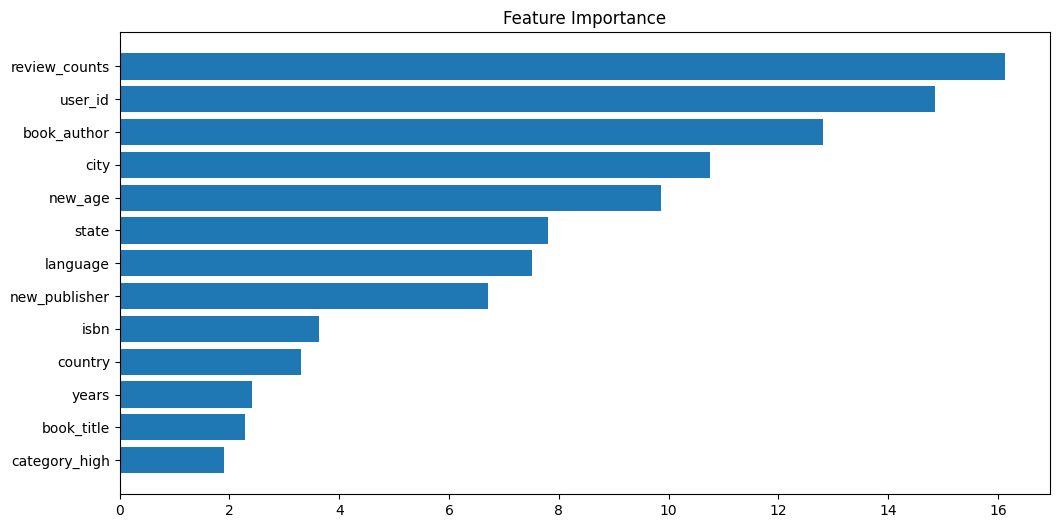

In [532]:
feature_importance = cat_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize = (12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align = 'center')
plt.yticks(range(len(sorted_idx)), np.array(X_data.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [533]:
test_ratings['rating'] = (pred_df['pred_0'] + pred_df['pred_1'] + pred_df['pred_2'] + pred_df['pred_3'] + pred_df['pred_4'] + 
                     pred_df['pred_5'] + pred_df['pred_6'] + pred_df['pred_7'] + pred_df['pred_8'] + pred_df['pred_9']) / 10
submit = test_ratings[['user_id', 'isbn', 'rating']]
submit

,user_id,isbn,rating
0,11676,0002005018,6.834884
1,116866,0002005018,7.058995
2,152827,0060973129,6.837433
3,157969,0374157065,6.623354
4,67958,0399135782,6.876133
...,...,...,...
76694,278543,1576734218,6.875116
76695,278563,3492223710,6.867771
76696,278633,1896095186,6.964139
76697,278668,8408044079,6.691789


In [534]:
submit.to_csv('./code/submit/CB_HPO_Pred_AVG.csv', index = False)